In [1]:
import pandas as pd

In [3]:
df=pd.read_csv("googl_data_cleaned (1).csv")

In [6]:
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
import ta  # For technical indicators

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
data = df[['Adj Close']].values

In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [9]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [10]:
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [11]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0577
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0054
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0037
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0032
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0034
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0028
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0030
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0036
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0034
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0029
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0024
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0027
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0030
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0024
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0024
Epoch 16/20
27/

In [12]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = sqrt(mean_squared_error(actual_prices, predicted_prices))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [13]:
dates = df['Date'].values[-len(actual_prices):]

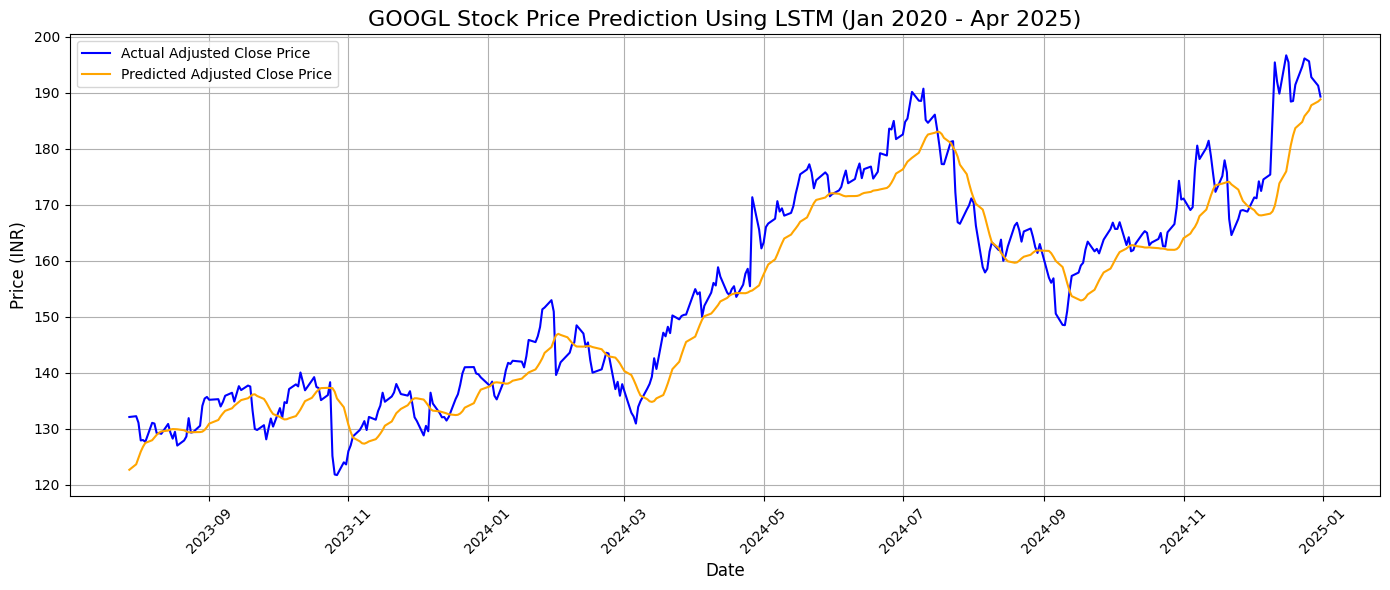

In [14]:
date_series = pd.to_datetime(dates.flatten())
actual_series = pd.Series(actual_prices.flatten(), index=date_series)
predicted_series = pd.Series(predicted_prices.flatten(), index=date_series)

# Filter between Jan 2020 and Apr 2025
start_date = '2020-01-01'
end_date = '2025-04-30'
actual_filtered = actual_series[start_date:end_date]
predicted_filtered = predicted_series[start_date:end_date]

# Plot
plt.figure(figsize=(14,6))
plt.plot(actual_filtered.index, actual_filtered.values, label='Actual Adjusted Close Price', color='blue')
plt.plot(predicted_filtered.index, predicted_filtered.values, label='Predicted Adjusted Close Price', color='orange')
plt.title('GOOGL Stock Price Prediction Using LSTM (Jan 2020 - Apr 2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (INR)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
print(f"Root Mean Squared Error: {rmse:.4f}")

Root Mean Squared Error: 5.9156


In [16]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")

Mean Absolute Error (MAE): 4.6377
R-squared (R²) Score: 0.9044


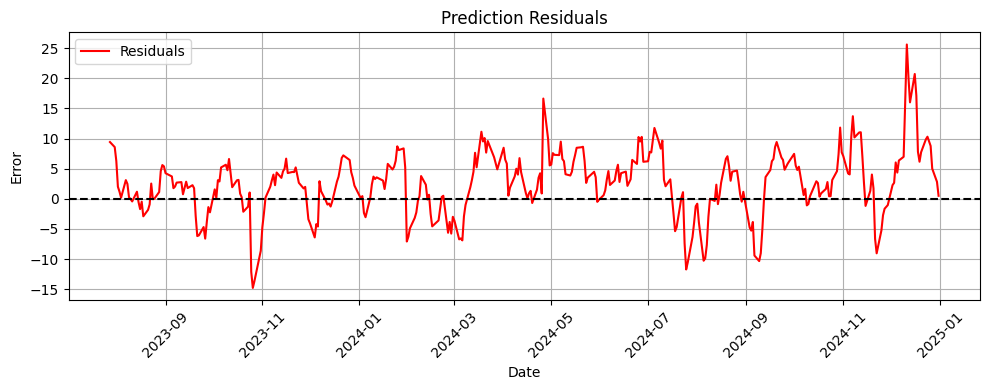

In [17]:
residuals = actual_prices - predicted_prices

plt.figure(figsize=(10, 4))
plt.plot(dates, residuals, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Prediction Residuals')
plt.xlabel('Date')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [19]:
from math import sqrt

In [20]:
train_size = int(len(data) * 0.7)
train, test = data[:train_size], data[train_size:]

In [21]:
model = ExponentialSmoothing(train,
                             trend='add',
                             seasonal='add',
                             seasonal_periods=12)  # Change if needed

ets_fit = model.fit(optimized=True)

In [22]:
forecast = ets_fit.forecast(len(test))

In [23]:
rmse = sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"ETS Forecast Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

ETS Forecast Evaluation:
RMSE: 26.4684
MAE: 22.1460
R² Score: -0.7609


In [24]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Use 'Adj Close' for forecasting
data = df['Adj Close']

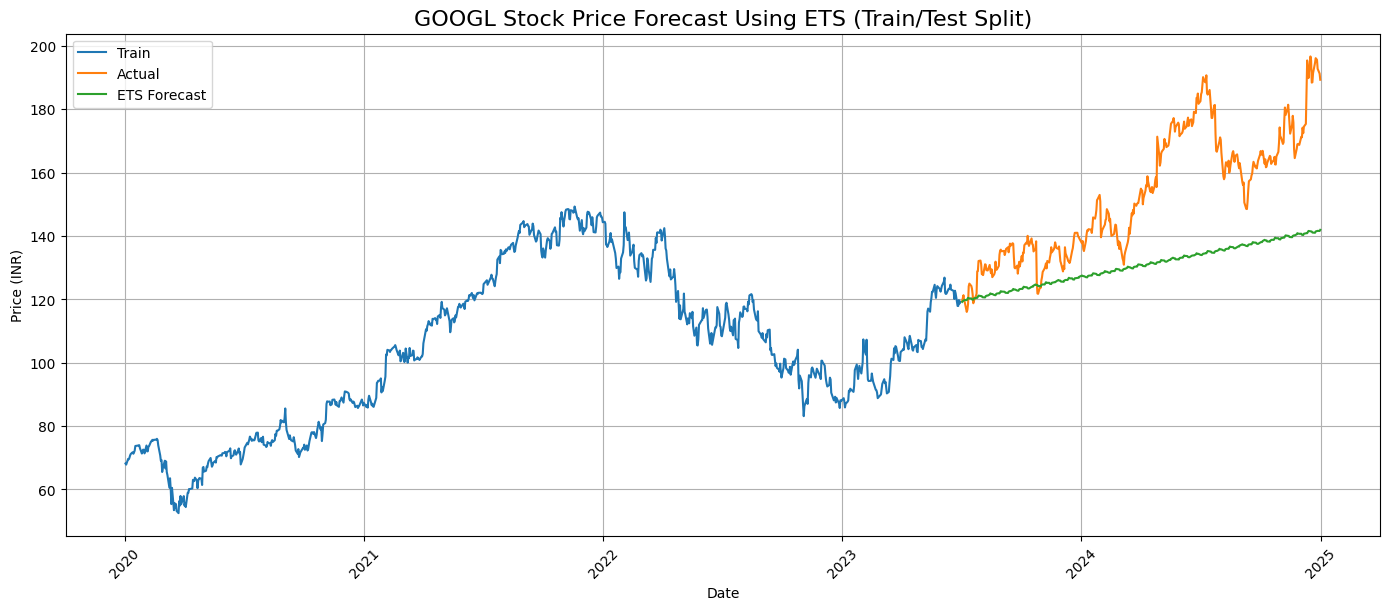

In [25]:
train_size = int(len(data) * 0.7)
train, test = data[:train_size], data[train_size:]

# Reset the index of train and test to a simple numerical index
train = train.reset_index()
test = test.reset_index()

# Now plot using the 'Date' column from train and test
plt.figure(figsize=(14,6))
plt.plot(train['Date'], train['Adj Close'], label='Train')
plt.plot(test['Date'], test['Adj Close'], label='Actual')
plt.plot(test['Date'], forecast, label='ETS Forecast')
plt.title('GOOGL Stock Price Forecast Using ETS (Train/Test Split)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [26]:
train_size = int(len(data) * 0.7)
train, test = data[:train_size], data[train_size:]

ets_model = ExponentialSmoothing(train.values, trend='add', seasonal='add', seasonal_periods=12).fit()

ets_pred = ets_model.forecast(len(test))

In [27]:
residuals = test - ets_pred


In [28]:
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

In [29]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(residuals_scaled)

In [30]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
X_test, _ = create_sequences(residuals_scaled)
lstm_pred_scaled = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [32]:
ets_pred_aligned = ets_pred[-len(lstm_pred):]
actual_aligned = test[-len(lstm_pred):]

In [33]:
hybrid_pred = ets_pred_aligned + lstm_pred.flatten()


In [34]:
rmse = sqrt(mean_squared_error(actual_aligned, hybrid_pred))
print(f"Hybrid Model RMSE: {rmse:.4f}")

Hybrid Model RMSE: 3.3220


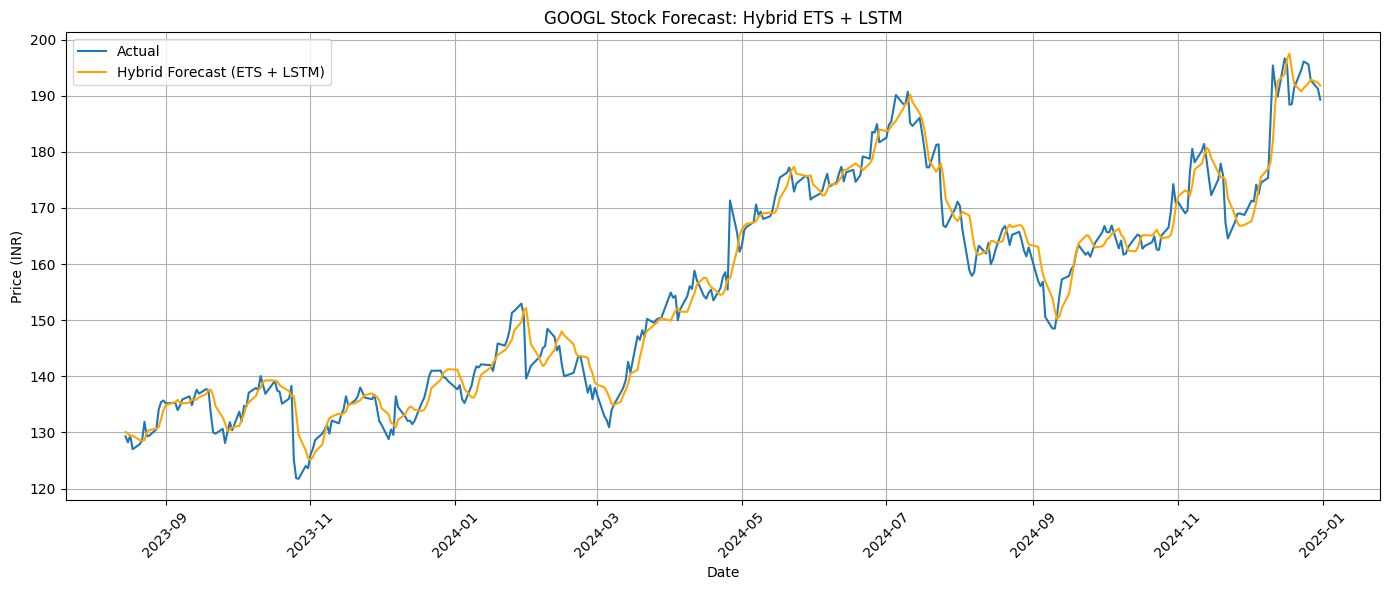

In [35]:
plt.figure(figsize=(14,6))
plt.plot(actual_aligned.index, actual_aligned, label='Actual')
plt.plot(actual_aligned.index, hybrid_pred, label='Hybrid Forecast (ETS + LSTM)', color='orange')
plt.title('GOOGL Stock Forecast: Hybrid ETS + LSTM')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
y_true_full = df['Adj Close'].values

In [37]:
y_true_full=y_true_full.flatten()

In [38]:
y_true_lstm = y_true_full[-len(predicted_prices):]
y_true_ets = y_true_full[-len(forecast):]
y_true_hybrid = y_true_full[-len(predicted_filtered):]

In [39]:
y_true_lstm = y_true_lstm.flatten()
y_true_ets = y_true_ets.flatten()
y_true_hybrid = y_true_hybrid.flatten()
predicted_prices=predicted_prices.flatten()

In [40]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    directional_accuracy = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

    print(f"\n📈 {model_name} Performance:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - Directional Accuracy: {directional_accuracy:.2%}")

# Evaluate
evaluate_model(y_true_lstm, predicted_prices, "LSTM")
evaluate_model(y_true_ets, forecast, "ETS")
evaluate_model(y_true_hybrid, predicted_filtered, "Hybrid LSTM + ETS")


📈 LSTM Performance:
  - MSE:  34.9942
  - RMSE: 5.9156
  - MAE:  4.6377
  - Directional Accuracy: 49.30%

📈 ETS Performance:
  - MSE:  700.5763
  - RMSE: 26.4684
  - MAE:  22.1460
  - Directional Accuracy: 47.21%

📈 Hybrid LSTM + ETS Performance:
  - MSE:  34.9942
  - RMSE: 5.9156
  - MAE:  4.6377
  - Directional Accuracy: 49.30%


In [41]:
hybrid_pred = 0.7 * lstm_pred + 0.3 * ets_pred

In [42]:
min_len = min(len(predicted_prices), len(forecast), len(df['Adj Close']))

lstm_pred = predicted_prices[-min_len:]
ets_pred = forecast[-min_len:]
y_true_stack = df['Adj Close'].values[-min_len:]

# Stack LSTM and ETS predictions as features
X_stack = np.column_stack((lstm_pred, ets_pred))

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create and fit the stacked model
stacked_model = LinearRegression()
stacked_model.fit(X_stack, y_true_stack)

# Predict using the stacked model
stacked_pred = stacked_model.predict(X_stack)

In [44]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    directional_accuracy = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

    print(f"\n📈 {model_name} Performance:")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - Directional Accuracy: {directional_accuracy:.2%}")

evaluate_model(y_true_stack, stacked_pred, "Stacked (LSTM + ETS)")


📈 Stacked (LSTM + ETS) Performance:
  - MSE:  27.2878
  - RMSE: 5.2238
  - MAE:  3.9756
  - Directional Accuracy: 49.03%


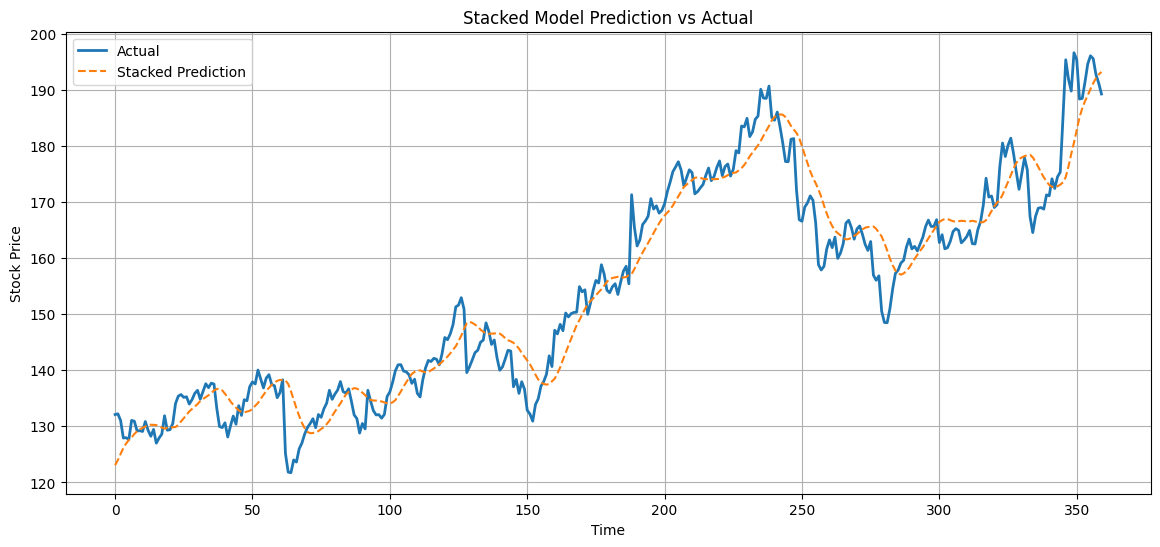

In [45]:
plt.figure(figsize=(14, 6))
plt.plot(y_true_stack, label="Actual", linewidth=2)
plt.plot(stacked_pred, label="Stacked Prediction", linestyle="--")
plt.title("Stacked Model Prediction vs Actual")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
df['Return'] = df['Adj Close'].pct_change()
df.dropna(inplace=True)  # Drop the first NaN

# Scale returns
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_returns = scaler.fit_transform(df['Return'].values.reshape(-1, 1))

In [47]:
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_returns, sequence_length)

# Split into train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0982
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0128
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0110
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0100
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0108
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0095
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0109
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0107
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0104
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0111
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0119
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0106
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0101
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0107
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0097
Epoch 16/20
30/

In [49]:
# Predict scaled returns
pred_scaled = model.predict(X_test)

# Invert scaling
pred_returns = scaler.inverse_transform(pred_scaled)
true_returns = scaler.inverse_transform(y_test)

# Reconstruct price from returns
start_price = df['Adj Close'].values[-len(pred_returns) - 1]  # one before the test starts

predicted_prices = [start_price]
for r in pred_returns:
    predicted_prices.append(predicted_prices[-1] * (1 + r[0]))
predicted_prices = predicted_prices[1:]

# True prices
true_prices = [start_price]
for r in true_returns:
    true_prices.append(true_prices[-1] * (1 + r[0]))
true_prices = true_prices[1:]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_directional_accuracy(true, pred):
    true_diff = np.diff(true)
    pred_diff = np.diff(pred)
    accuracy = np.mean(np.sign(true_diff) == np.sign(pred_diff))
    return accuracy

def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    da = evaluate_directional_accuracy(y_true, y_pred)

    print(f"\n📊 {name} Evaluation")
    print(f"  - MSE:  {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE:  {mae:.4f}")
    print(f"  - Directional Accuracy: {da:.2%}")

evaluate(true_prices, predicted_prices, "LSTM (Return-based)")


📊 LSTM (Return-based) Evaluation
  - MSE:  92.5039
  - RMSE: 9.6179
  - MAE:  8.1424
  - Directional Accuracy: 55.23%


In [51]:
df['Return'] = df['Adj Close'].pct_change()
df.dropna(inplace=True)

returns = df['Return'].values.reshape(-1, 1)

# Use raw returns directly
X, y = create_sequences(returns, sequence_length)

In [52]:
df['Direction'] = (df['Return'] > 0).astype(int)

In [53]:
y = df['Direction'].values[sequence_length:]

In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Normalize returns for input (optional, improves LSTM convergence)
scaler = MinMaxScaler()
scaled_returns = scaler.fit_transform(df['Return'].values.reshape(-1, 1))

# Create sequences
def create_classifier_sequences(data, labels, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(labels[i])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_classifier_sequences(scaled_returns, df['Direction'].values, sequence_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [62]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(70, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(70, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # sigmoid for binary output

model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.5024 - loss: 0.6931 - val_accuracy: 0.5958 - val_loss: 0.6780
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5357 - loss: 0.6940 - val_accuracy: 0.4917 - val_loss: 0.6931
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5084 - loss: 0.6932 - val_accuracy: 0.5958 - val_loss: 0.6825
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5304 - loss: 0.6924 - val_accuracy: 0.5958 - val_loss: 0.6848
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5201 - loss: 0.6930 - val_accuracy: 0.5958 - val_loss: 0.6834
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5367 - loss: 0.6919 - val_accuracy: 0.5958 - val_loss: 0.6839
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5264 - loss: 0.6922 - val_accuracy: 0.5958 - val_loss: 0.6830
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.5958

In [63]:
# Predict class probabilities
y_probs = model.predict(X_test)

# Convert probabilities to binary predictions (0/1)
y_pred = (y_probs.flatten() > 0.5).astype(int)

# Evaluate directional accuracy
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Directional Accuracy (LSTM Classifier): {acc:.2%}")
print(classification_report(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step

🎯 Directional Accuracy (LSTM Classifier): 59.58%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.60      1.00      0.75       143

    accuracy                           0.60       240
   macro avg       0.30      0.50      0.37       240
weighted avg       0.36      0.60      0.44       240



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
classifier = Sequential()
classifier.add(LSTM(70, return_sequences=True, input_shape=(X_train.shape[1], 1)))
classifier.add(Dropout(0.3))
classifier.add(LSTM(70, return_sequences=False))
classifier.add(Dropout(0.3))
classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.5069 - loss: 0.6937 - val_accuracy: 0.5958 - val_loss: 0.6872
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.5292 - loss: 0.6907 - val_accuracy: 0.5958 - val_loss: 0.6843
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5096 - loss: 0.6945 - val_accuracy: 0.5958 - val_loss: 0.6829
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5220 - loss: 0.6919 - val_accuracy: 0.5958 - val_loss: 0.6813
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5235 - loss: 0.6938 - val_accuracy: 0.5958 - val_loss: 0.6873
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5429 - loss: 0.6902 - val_accuracy: 0.5958 - val_loss: 0.6815
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5484 - loss: 0.6877 - val_accuracy: 0.5958 - val_loss: 0.6886
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5333 - loss: 0.6907 - val_accuracy: 0.5958 - 

In [66]:
classifier_return_pred = classifier.predict(X_test).flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [67]:
pred_direction = (classifier.predict(X_test) > 0.5).astype(int)
final_pred = []

for i in range(len(classifier_return_pred)):
    if pred_direction[i] == 1:
        final_pred.append(classifier_return_pred[i])
    else:
        # Dampen or zero out the return if classifier says "don't buy"
        final_pred.append(min(classifier_return_pred[i], 0))
final_pred = np.array(final_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [69]:
# Re-label Direction more strictly to reduce noise
df['Direction'] = df['Return'].apply(lambda x: 1 if x > 0.002 else 0)

def create_sequences(data, labels, seq_len=60):
        X, y = [], []
        for i in range(seq_len, len(data)):
            X.append(data[i-seq_len:i])
            y.append(labels[i])  # Using the labels
        return np.array(X), np.array(y)
# Create sequences again
X_clf, y_clf = create_sequences(scaled_returns, df['Direction'].values, sequence_length)

# Train/Test split
X_train_clf, X_test_clf = X_clf[:split], X_clf[split:]
y_train_clf, y_test_clf = y_clf[:split], y_clf[split:]

# =====================
# Classifier Model (Upgraded)
# =====================
from keras.layers import Bidirectional

classifier = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

classifier.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train_clf, y_train_clf, epochs=30, batch_size=32, validation_data=(X_test_clf, y_test_clf), verbose=0)

# Predict and evaluate
y_probs = classifier.predict(X_test_clf).flatten()

# Try different thresholds
best_acc = 0
best_thresh = 0.5

for thresh in np.arange(0.4, 0.7, 0.01):
    preds = (y_probs > thresh).astype(int)
    acc = accuracy_score(y_test_clf, preds)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

print(f"🎯 Best Directional Accuracy: {best_acc:.2%} at threshold {best_thresh:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
🎯 Best Directional Accuracy: 56.67% at threshold 0.40


In [70]:
pip install keras-tuner ta

In [71]:
# -----------------------------
# Load and Prepare Data
# -----------------------------
file_path = "/content/googl_data_cleaned (1).csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} not found.")

df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [72]:
# -----------------------------
# Add Features
# -----------------------------
df['MA7'] = df['Adj Close'].rolling(window=7).mean()
df['MA21'] = df['Adj Close'].rolling(window=21).mean()
df['MACD'] = ta.trend.macd(df['Adj Close'])
df['RSI'] = ta.momentum.rsi(df['Adj Close'])
df['Volume'] = df['Volume']

In [73]:
# Fill NA values
df = df.fillna(method='bfill')

<ipython-input-73-8853d86914ae>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


In [74]:
# Features for modeling
feature_cols = ['Adj Close', 'Volume', 'MA7', 'MA21', 'MACD', 'RSI']
features = df[feature_cols].values

In [75]:
# -----------------------------
# Scale Features
# -----------------------------
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

In [76]:
# -----------------------------
# Create Sequences
# -----------------------------
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])  # Predicting 'Adj Close'
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_features, sequence_length)

In [77]:
# -----------------------------
# Train/Test Split
# -----------------------------
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [78]:
# -----------------------------
# Hyperparameter Model Builder
# -----------------------------
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("units_1", 32, 128, step=32),
        return_sequences=True,
        input_shape=(X.shape[1], X.shape[2])
    ))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int("units_2", 32, 128, step=32)
    ))
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss='mean_squared_error'
    )
    return model

In [79]:
# -----------------------------
# Hyperparameter Tuning
# -----------------------------
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='lstm_stock_tune'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_split=0.1,
             epochs=50,
             batch_size=32,
             callbacks=[early_stop],
             verbose=1)

Trial 10 Complete [00h 00m 52s]
val_loss: 0.00046266880235634744

Best val_loss So Far: 0.0003498220175970346
Total elapsed time: 00h 11m 42s


In [80]:
# -----------------------------
# Best Model and Prediction
# -----------------------------
best_model = tuner.get_best_models(1)[0]
predicted = best_model.predict(X_test)

def inverse_transform_column(pred, scaler, col_index):
    dummy = np.zeros((len(pred), scaler.n_features_in_))
    dummy[:, col_index] = pred.flatten()
    return scaler.inverse_transform(dummy)[:, col_index]

predicted_prices = inverse_transform_column(predicted, scaler, 0)
actual_prices = inverse_transform_column(y_test.reshape(-1, 1), scaler, 0)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


In [81]:
# -----------------------------
# Metrics
# -----------------------------
rmse = sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📊 R² Score: {r2:.4f}")
print(f"📌 Best Parameters: {tuner.get_best_hyperparameters(1)[0].values}")

📊 RMSE: 5.45
📊 MAE: 4.13
📊 R² Score: 0.9190
📌 Best Parameters: {'units_1': 128, 'dropout_1': 0.5, 'units_2': 96, 'dropout_2': 0.2, 'learning_rate': 0.01}


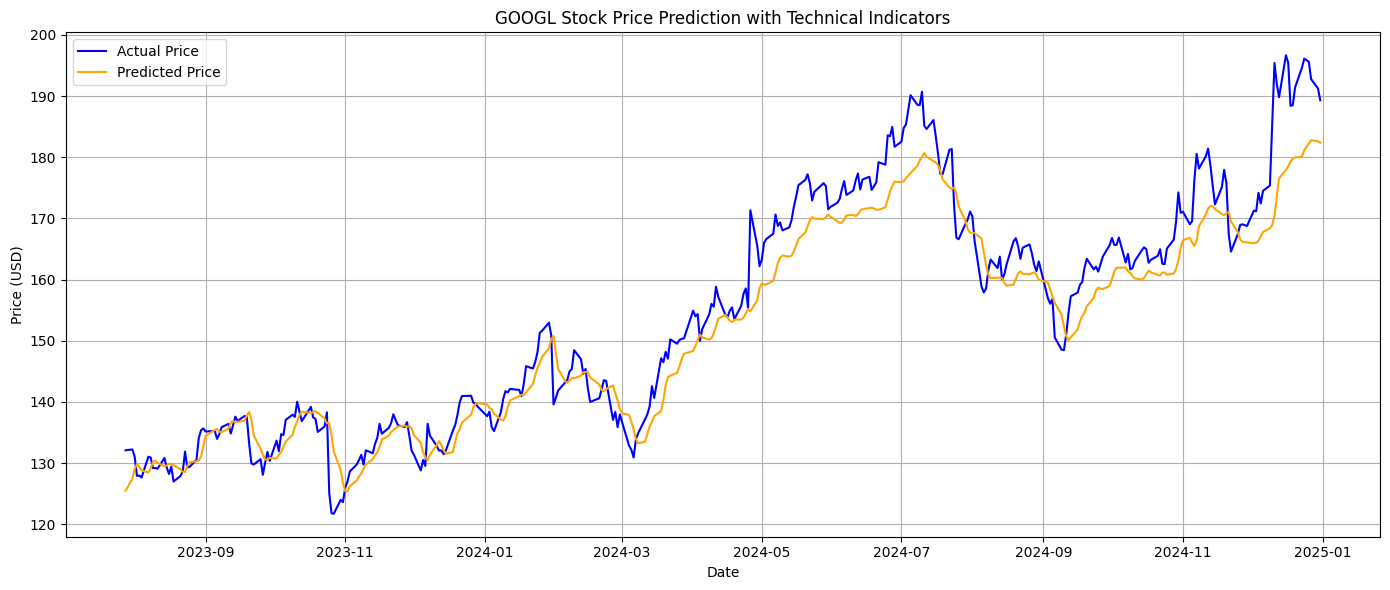

In [82]:
# -----------------------------
# Plot
# -----------------------------
dates = df['Date'].values[-len(actual_prices):]

plt.figure(figsize=(14, 6))
plt.plot(dates, actual_prices, label='Actual Price', color='blue')
plt.plot(dates, predicted_prices, label='Predicted Price', color='orange')
plt.title("GOOGL Stock Price Prediction with Technical Indicators")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0289 - val_loss: 0.0047
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 0.0027 - val_loss: 9.8764e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0029 - val_loss: 9.9109e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0029 - val_loss: 9.7389e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.0024 - val_loss: 8.6216e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0022 - val_loss: 8.5972e-04
Epoch 12/100
27/27 ━

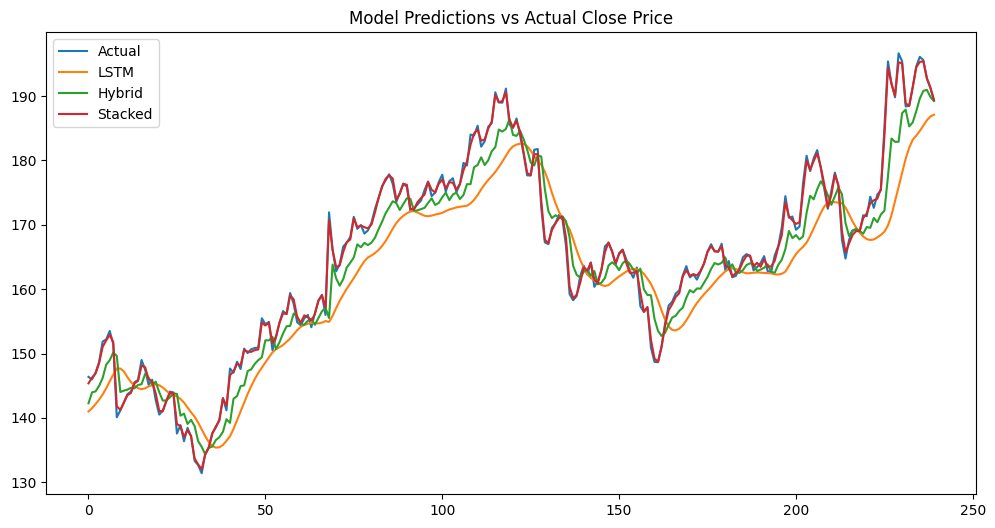

In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("googl_data_cleaned (1).csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Use more features
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)

SEQ_LEN = 60
def create_sequences(data):
    X, y = [], []
    for i in range(SEQ_LEN, len(data)):
        X.append(data[i-SEQ_LEN:i])
        y.append(data[i, 3])  # 'Close' is at index 3
    return np.array(X), np.array(y)

X, y = create_sequences(scaled)
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(X))], y[int(0.8*len(X)):]

# Build improved LSTM
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm_model((SEQ_LEN, 5))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

# Predict and inverse transform only 'Close'
pred_scaled = model.predict(X_test)
true_close = scaled[SEQ_LEN+len(y_train):, 3].reshape(-1, 1)
pred_close = pred_scaled.reshape(-1, 1)

# Rebuild Close-only scaler for inverse transform
close_scaler = MinMaxScaler()
close_scaler.fit(df[['Close']])
y_test_real = close_scaler.inverse_transform(true_close)
lstm_pred = close_scaler.inverse_transform(pred_close)

# ETS Model
ets_model = ExponentialSmoothing(df['Close'], trend='add', seasonal=None)
ets_fit = ets_model.fit()
ets_forecast = ets_fit.fittedvalues[SEQ_LEN:]
ets_pred = ets_forecast[-len(y_test_real):].values.reshape(-1, 1)

# Hybrid
hybrid_pred = (lstm_pred + ets_pred) / 2

# Stacked with XGBoost
stack_data = np.hstack((lstm_pred, ets_pred))
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(stack_data, y_test_real)
stacked_pred = xgb.predict(stack_data).reshape(-1, 1)

# Directional accuracy
def directional_accuracy(actual, predicted):
    actual_direction = np.sign(np.diff(actual.flatten()))
    predicted_direction = np.sign(np.diff(predicted.flatten()))
    return np.mean(actual_direction == predicted_direction) * 100

acc_lstm = directional_accuracy(y_test_real, lstm_pred)
acc_ets = directional_accuracy(y_test_real, ets_pred)
acc_hybrid = directional_accuracy(y_test_real, hybrid_pred)
acc_stacked = directional_accuracy(y_test_real, stacked_pred)

print(f"LSTM Accuracy: {acc_lstm:.2f}%")
print(f"ETS Accuracy: {acc_ets:.2f}%")
print(f"Hybrid Accuracy: {acc_hybrid:.2f}%")
print(f"Stacked Accuracy: {acc_stacked:.2f}%")

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Actual')
plt.plot(lstm_pred, label='LSTM')
plt.plot(hybrid_pred, label='Hybrid')
plt.plot(stacked_pred, label='Stacked')
plt.legend()
plt.title("Model Predictions vs Actual Close Price")
plt.show()


In [95]:
# -----------------------------
# Save Model and Scaler
# -----------------------------
best_model.save("best_lstm_tech_indicators.h5")
joblib.dump(scaler, "scaler.save")
print("✅ Enhanced model and scaler saved.")

✅ Enhanced model and scaler saved.
